#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14073796777937585202
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11511235500128952442
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   1%|1         | 2/148 [00:00<00:08, 17.54it/s]

r_index: 100%|##########| 91/91 [00:00<00:00, 614.73it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(869, 15)
(1216, 15)
(1090, 15)


StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(695, 15)
(972, 15)
(872, 15)


#### 10-Fold Crossvalidation

In [23]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [24]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [25]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:17:04,514] A new study created in memory with name: rf_parameter_opt
[I 2023-08-24 14:17:04,946] Trial 0 finished with value: 0.46684113964894036 and parameters: {'n_estimators': 22, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 12}. Best is trial 0 with value: 0.46684113964894036.
[I 2023-08-24 14:17:05,212] Trial 1 finished with value: 0.43474752228642116 and parameters: {'n_estimators': 18, 'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 20}. Best is trial 0 with value: 0.46684113964894036.
[I 2023-08-24 14:17:05,925] Trial 2 finished with value: 0.16821506259242583 and parameters: {'n_estimators': 99, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 0 with value: 0.46684113964894036.
[I 2023-08-24 14:17:07,239] Trial 3 finished with value: 0.4934613900600725 and parameters: {'n_estimators': 57, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8}. Best is trial 3 with value: 0.4934613900600725.
[I 2

Best r2:  0.5018444288175135
Best trial: {'n_estimators': 57, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 57, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [29]:
study.best_trial.params["n_estimators"]

57

In [30]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=57, random_state=42)

In [31]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [32]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [33]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.19600290851616636
Test RMSE:  0.45881124468211826


In [34]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8492172167644302
Test R2:  0.019306499359117324


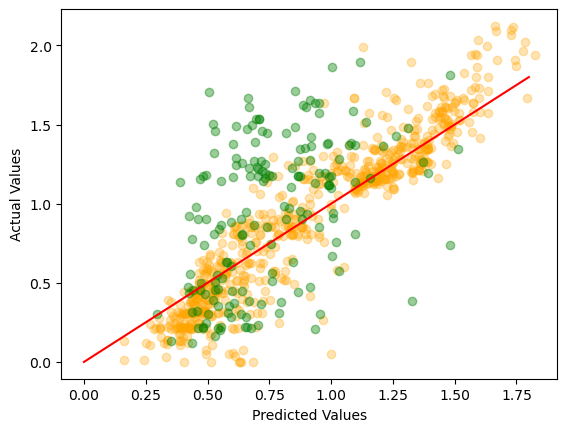

In [35]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [36]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:18:55,934] A new study created in memory with name: rf_parameter_opt
[I 2023-08-24 14:18:56,981] Trial 0 finished with value: 0.36421088047724537 and parameters: {'n_estimators': 87, 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 18}. Best is trial 0 with value: 0.36421088047724537.
[I 2023-08-24 14:18:57,617] Trial 1 finished with value: 0.23807213228536064 and parameters: {'n_estimators': 76, 'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 12}. Best is trial 0 with value: 0.36421088047724537.
[I 2023-08-24 14:18:59,261] Trial 2 finished with value: 0.46463985818200715 and parameters: {'n_estimators': 71, 'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 18}. Best is trial 2 with value: 0.46463985818200715.
[I 2023-08-24 14:19:00,882] Trial 3 finished with value: 0.4851435460998478 and parameters: {'n_estimators': 59, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 17}. Best is trial 3 with value: 0.4851435460998478.
[I

Best r2:  0.5454346007070547
Best trial: {'n_estimators': 58, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [37]:
optuna.visualization.plot_parallel_coordinate(study)

In [38]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 58, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


58

In [39]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, n_estimators=58, random_state=42)

In [40]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [41]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.030874000147245163
Test RMSE:  0.07267760429846182


In [42]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8648694379843627
Test R2:  0.23287486150528736


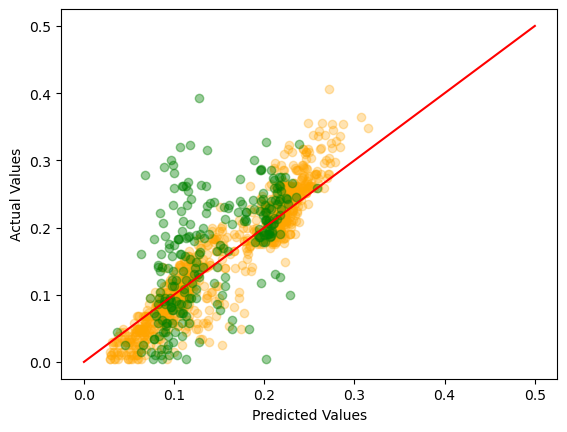

In [43]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [44]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:21:31,484] A new study created in memory with name: rf_parameter_opt
[I 2023-08-24 14:21:31,738] Trial 0 finished with value: 0.2015196113624011 and parameters: {'n_estimators': 29, 'max_depth': 1, 'min_samples_leaf': 19, 'min_samples_split': 4}. Best is trial 0 with value: 0.2015196113624011.
[I 2023-08-24 14:21:32,304] Trial 1 finished with value: 0.7383376009293208 and parameters: {'n_estimators': 22, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 3}. Best is trial 1 with value: 0.7383376009293208.
[I 2023-08-24 14:21:33,706] Trial 2 finished with value: 0.6075894910218826 and parameters: {'n_estimators': 94, 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 18}. Best is trial 1 with value: 0.7383376009293208.
[I 2023-08-24 14:21:34,444] Trial 3 finished with value: 0.6053826514398472 and parameters: {'n_estimators': 49, 'max_depth': 4, 'min_samples_leaf': 19, 'min_samples_split': 16}. Best is trial 1 with value: 0.7383376009293208.
[I 2023-0

Best r2:  0.796764720206188
Best trial: {'n_estimators': 89, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [45]:
optuna.visualization.plot_parallel_coordinate(study)

In [46]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 89, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


89

In [47]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=89,
                      random_state=42)

In [48]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [49]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.2876313246481002
Test RMSE:  0.6468743693083591


In [50]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9429658768580365
Test R2:  0.7320512145812428


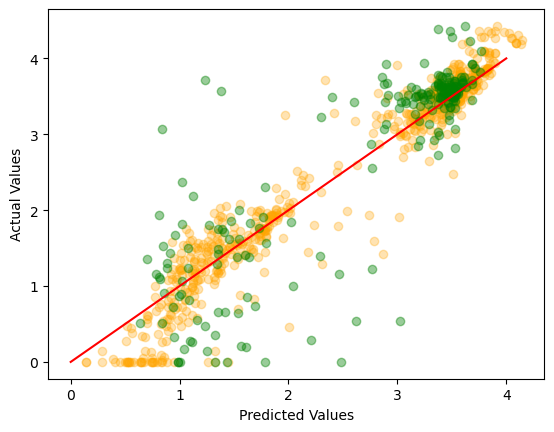

In [51]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()